In [326]:
import pandas as pd
import time
from datetime import datetime
from datetime import timedelta
import pickle
import math
from collections import defaultdict
from pyspark.sql.functions import countDistinct ,approxCountDistinct
import matplotlib.pyplot as plt
import numpy as np
import shap
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split #split
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
import os
from utils.forwardSplit import *
from xgboost import XGBClassifier
%matplotlib inline
from pdpbox import pdp,get_dataset,info_plots
from pdpbox import pdp,get_dataset,info_plots
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [357]:
train = pd.read_csv('/root/data/dinglang.wu/my/match/2020厦门国际银行数创金融杯建模大赛/mydata/train.csv',index_col=0,nrows=1000)
# test = pd.read_csv('/root/data/dinglang.wu/my/match/2020厦门国际银行数创金融杯建模大赛/mydata/test.csv',index_col = 0,nrows = 1000  )

#### 模型训练

In [358]:
train = train.drop(['bef_label','cust_no'],axis=1)
y = train['label']
X = train.copy()
X = X.drop('label',axis=1)
TEST_SIZE = 0.3
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [359]:
params = {

    'learning_rate': 0.01,
}
plst = list(params.items())

In [360]:
#model_train
model = xgboost.train(plst, xgboost.DMatrix(X_train, label=y_train), 100)#DMatrix解析文件:XGBoost不支持分类功能

In [ ]:
#保存模型
os.mknod("saved_model3") 
joblib.dump(model, 'saved_model3')       # 保存模型，需先建立saved_model文件夹

In [347]:
#model = joblib.load('saved_model2')    # 下载模型

#### 特征筛选

In [361]:
def VI_shapley(shap_values,X_train):
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False)
    importance_df['shap_importance'] = importance_df['shap_importance'].astype('float')
    return importance_df

# 对model的编码，删除binf
model_modify = model.save_raw()[4:]
def myfun(self=None):
    return model_modify

def select_ft(model, X, y,n_ft = 30 ,cor_thr = 0.9):
    model.save_raw = myfun
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    #feature importance :
    vi_shp = VI_shapley(shap_values,X)
    #sort:
    best_features = vi_shp.sort_values('shap_importance',ascending=False).reset_index(drop=True)
    #top_30 feature
    initial_ft = best_features.iloc[0:n_ft,0].tolist() #Getting the most Importance (according to shap)
    #calculate feature corr
    cormtx = X[initial_ft].corr()
    #Create a lower triangle from a correlation matrix
    mask = np.zeros_like(cormtx, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cormtx[mask]=np.NaN
    if sum((cormtx>cor_thr).values.flatten()):
        #melt函数相当于降维，将数组进行垂直平铺
        cor_info = cormtx.reset_index().melt('index')  
        print('A high correlation between features was found!')
        print(cor_info[cor_info.value>cor_thr])
    return initial_ft
ftlist = select_ft(model,X_train,y_train)

A high correlation between features was found!
                             index                      variable     value
6          X9_min_window_3_month_3      X9_last_window_3_month_3  0.993724
8          X9_sum_window_6_month_0      X9_last_window_3_month_3  0.986646
41   X9_diff_mean_window_4_month_2  X9_diff_sum_window_4_month_2  0.975678
89    X9_diff_min_window_3_month_3  X9_diff_min_window_4_month_2  0.998802
95        C1_last_window_3_month_3      C3_last_window_3_month_3  0.985483
104       C3_last_window_3_month_2      C3_last_window_3_month_3  0.997230
106        C3_sum_window_4_month_2      C3_last_window_3_month_3  0.988109
164       C3_last_window_3_month_2      C1_last_window_3_month_3  0.984165
166        C3_sum_window_4_month_2      C1_last_window_3_month_3  0.973587
188        X9_sum_window_6_month_0       X9_min_window_3_month_3  0.990174
436        C3_sum_window_4_month_2      C3_last_window_3_month_2  0.989528


#### 数据分箱

In [363]:
select_fea = ftlist
select_fea.append('label')
x_train = train[select_fea]
x_train.dropna(inplace=True)
x_train.reset_index(drop=True,inplace=True)
y_train = x_train['label']
x_train.drop('label',axis=1,inplace=True)

In [364]:
cols=[]
for col in x_train.columns:
    l = [np.percentile(x_train[col],0),np.percentile(x_train[col],25),np.percentile(x_train[col],50),np.percentile(x_train[col],75),np.percentile(x_train[col],100)]
    if len(np.unique(l))==5:
        cols.append(col)
x_train = x_train[cols]
for col in cols:
    l = [np.percentile(x_train[col],0),np.percentile(x_train[col],25),np.percentile(x_train[col],50),np.percentile(x_train[col],75),np.percentile(x_train[col],100)]
    x_train[col] = pd.cut(x=x_train[col], bins=l, labels=[0,1,2,3])
x_train.fillna(0,inplace=True)
x_train = x_train.astype('int')

#### 模型再训练

In [369]:
model = xgboost.train(plst, xgboost.DMatrix(x_train, label=y_train),100)

In [ ]:
#保存模型
os.mknod("saved_model3") 
joblib.dump(model, 'saved_model3')  

In [ ]:
model = joblib.load('saved_model3') 

#### 计算shap值

In [370]:
shap.initjs()
model.save_raw = myfun
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xgboost.DMatrix(x_train[cols]))#, label=y_train

In [371]:
shap_values_df = pd.DataFrame(shap_values, columns=cols).add_suffix('_shap')

In [372]:
shap_values_df_all = pd.concat([x_train,shap_values_df],axis=1)

In [373]:
shap_values_df

X9_last_window_3_month_3_shap  X9_diff_sum_window_4_month_2_shap  \
0                         0.052019                          -0.003413   
1                         0.079651                           0.030589   
2                        -0.136599                          -0.015585   
3                        -0.009573                           0.002129   
4                        -0.078511                           0.004369   
..                             ...                                ...   
96                        0.064723                          -0.010501   
97                       -0.033348                           0.033615   
98                       -0.096510                          -0.025894   
99                       -0.001852                           0.023997   
100                      -0.094783                           0.038484   

     X9_diff_min_window_4_month_2_shap  C3_last_window_3_month_3_shap  \
0                             0.006943                       0.042405   
1                             0.013372                       0.100295   
2                             0.047030                       0.128583   
3                            -0.004406                      -0.153726   
4                             0.012093                      -0.020376   
..                                 ...                            ...   
96                           -0.000317                       0.033459   
97                            0.006992                      -0.099535   
98                           -0.031114                      -0.282008   
99                            0.013760                      -0.069559   
100                           0.006783                      -0.123629   

     X9_diff_sum_window_3_month_3_shap  C1_last_window_3_month_3_shap  \
0                            -0.105718                      -0.006576   
1                             0.086127                       0.010407   
2                             0.049582                       0.015737   
3                             0.023945                      -0.004416   
4                             0.014295                      -0.000934   
..                                 ...                            ...   
96                            0.013549                       0.008587   
97                           -0.110035                       0.006975   
98                            0.024609                      -0.017580   
99                           -0.418446                       0.015593   
100                          -0.164428                       0.006643   

     X9_min_window_3_month_3_shap  X9_diff_max_window_3_month_3_shap  \
0                       -0.001860                          -0.007150   
1                       -0.000869                           0.002878   
2                        0.008843                           0.000048   
3                       -0.002145                           0.017466   
4                        0.039361                          -0.006483   
..                            ...                                ...   
96                      -0.000702                           0.001390   
97                       0.008339                          -0.000470   
98                       0.018052                          -0.002510   
99                      -0.000557                           0.002139   
100                      0.004634                          -0.007500   

     X9_sum_window_6_month_0_shap  C3_diff_min_window_3_month_0_shap  ...  \
0                       -0.014766                          -0.015739  ...   
1                       -0.032840                          -0.012731  ...   
2                        0.046427                          -0.027386  ...   
3                        0.264359                           0.082675  ...   
4                        0.182554                           0.132313  ...   
..                            ...              

In [374]:
shap_values_df['C3_last_window_3_month_3_shap'].abs().mean()

0.11290151

### shap值解释

#### 特征解释

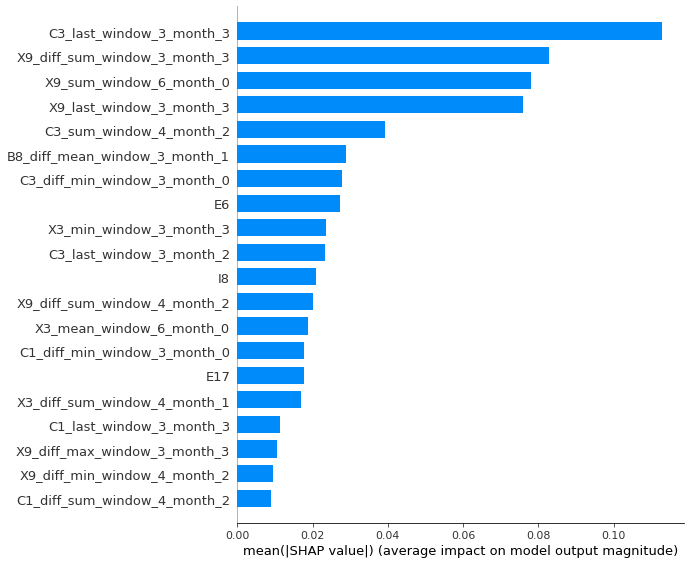

In [375]:
#特征重要性
shap.summary_plot(shap_values,x_train,plot_type='bar')

In [376]:
shap_features = shap_values_df_all.filter(regex='shap$',axis=1)
cols = shap_values_df_all.drop(shap_features.columns,axis=1).columns.tolist()
featrue_avgshap = shap_features.mean().reset_index().rename(columns={'index':'feature',0:'shap_mean'})

In [377]:
featrue_avgshap_label = dict()
for col in cols:
    for i in range(len(np.unique(shap_values_df_all[col]))):
        c = col+'_'+str(i)
        try:
            featrue_avgshap_label[c] = shap_values_df_all[shap_values_df_all[col]==i].filter(regex=col+'_shap$').mean().values[0]
        except:
            featrue_avgshap_label[c]=0

In [378]:
featrue_avgshap_label = pd.DataFrame([featrue_avgshap_label]).T.reset_index().rename(columns={'index':'featrue_lable',0:'shap_mean'})

In [379]:
decri_minus = {}
featrue_minus = []
decri_positive = {}
featrue_positive = []
for col in featrue_avgshap_label['featrue_lable']:
    if featrue_avgshap_label[featrue_avgshap_label['featrue_lable']==col]['shap_mean'].values[0] <0:
        decri_minus[col[:-2]+' = '+col[-1]+' 组'] = featrue_avgshap_label[featrue_avgshap_label['featrue_lable']==col]['shap_mean'].values[0]
        featrue_minus.append(col[:-2])
    else : 
        decri_positive[col[:-2]+' = '+col[-1]+' 组'] = featrue_avgshap_label[featrue_avgshap_label['featrue_lable']==col]['shap_mean'].values[0]
        featrue_positive.append(col[:-2])

In [380]:
decri_minus = pd.DataFrame([decri_minus]).T.reset_index().rename(columns={'index':'以下因素对分数有负影响',0:'得分'})
decri_minus['featrue'] = featrue_minus
decri_positive = pd.DataFrame([decri_positive]).T.reset_index().rename(columns={'index':'以下因素对分数有正影响',0:'得分'})
decri_positive['featrue'] = featrue_positive

In [381]:
decri_positive.head(2)

以下因素对分数有正影响        得分                   featrue
0  X9_last_window_3_month_3 = 0 组  0.058100  X9_last_window_3_month_3
1  X9_last_window_3_month_3 = 1 组  0.044902  X9_last_window_3_month_3

In [382]:
decri_minus.head(2)

以下因素对分数有负影响        得分                       featrue
0      X9_last_window_3_month_3 = 3 组 -0.173115      X9_last_window_3_month_3
1  X9_diff_sum_window_4_month_2 = 2 组 -0.001855  X9_diff_sum_window_4_month_2

In [383]:
list4=[]
for col in cols:
    list1 = []
    list2 = col+'的得分为：'+str(featrue_avgshap[featrue_avgshap['feature'] ==col+'_shap']['shap_mean'].values[0])
    list1.append(list2)
    for i in range(len(np.unique(shap_values_df_all[col]))):
        score = featrue_avgshap_label[featrue_avgshap_label['featrue_lable']==col+'_'+str(i)]['shap_mean'].values[0]
        list3 = '其中'+col+'等于'+str(i)+'组'+'贡献了'+str(score)
        list1.append(list3)

    list4.append(list1)
featrue_devote = pd.DataFrame(list4).rename(columns={0:'特征得分',1:'因素0的贡献分',2:'因素1的贡献分',3:'因素2的贡献分',4:'因素3的贡献分'})

In [384]:
featrue_devote.head(2)

特征得分  \
0      X9_last_window_3_month_3的得分为：-0.015730051   
1  X9_diff_sum_window_4_month_2的得分为：0.0058212187   

                                             因素0的贡献分  \
0  其中X9_last_window_3_month_3等于0组贡献了0.05809969455...   
1  其中X9_diff_sum_window_4_month_2等于0组贡献了0.0343662...   

                                             因素1的贡献分  \
0  其中X9_last_window_3_month_3等于1组贡献了0.04490215331...   
1  其中X9_diff_sum_window_4_month_2等于1组贡献了0.0112414...   

                                             因素2的贡献分  \
0  其中X9_last_window_3_month_3等于2组贡献了0.00423979898...   
1  其中X9_diff_sum_window_4_month_2等于2组贡献了-0.001854...   

                                             因素3的贡献分  
0  其中X9_last_window_3_month_3等于3组贡献了-0.1731150299...  
1  其中X9_diff_sum_window_4_month_2等于3组贡献了-0.021609...

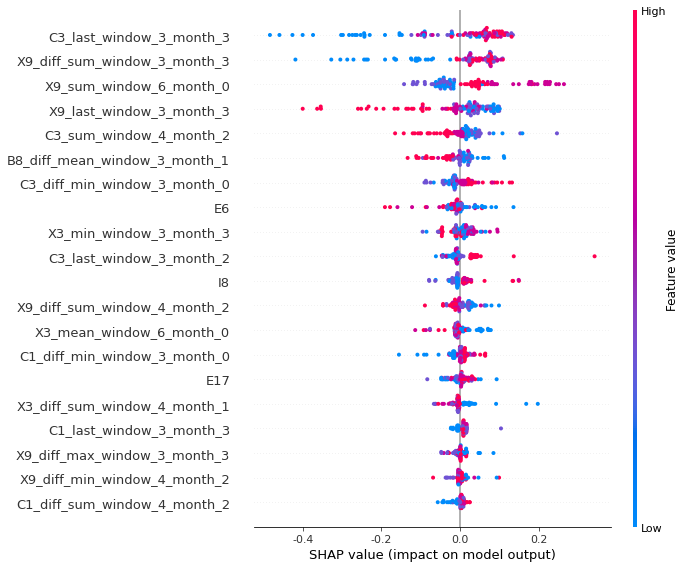

In [385]:
shap.summary_plot(shap_values,x_train)

#### 样本解释

In [386]:
explainer.expected_value

0.3655973

In [387]:
#单个样本解释
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [388]:
#所有样本解释
shap.force_plot(explainer.expected_value, shap_values, x_train)

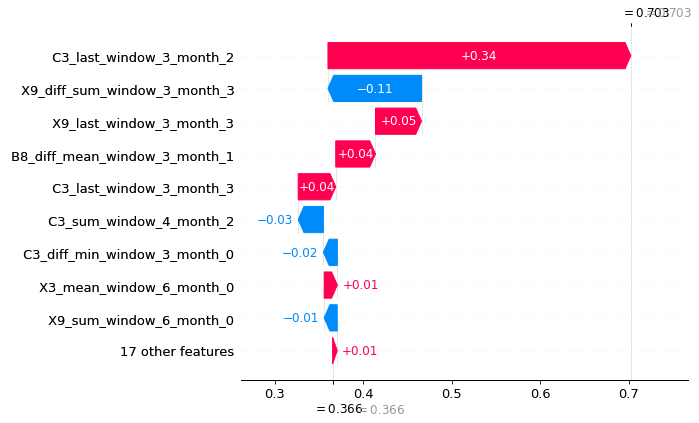

In [389]:
shap.waterfall_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

#### 决策图

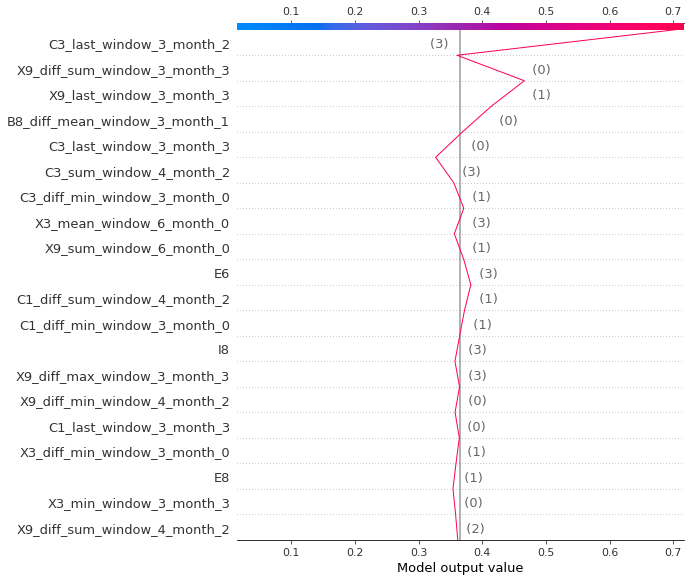

In [390]:
shap.decision_plot(explainer.expected_value,shap_values[0],x_train.iloc[0,:])

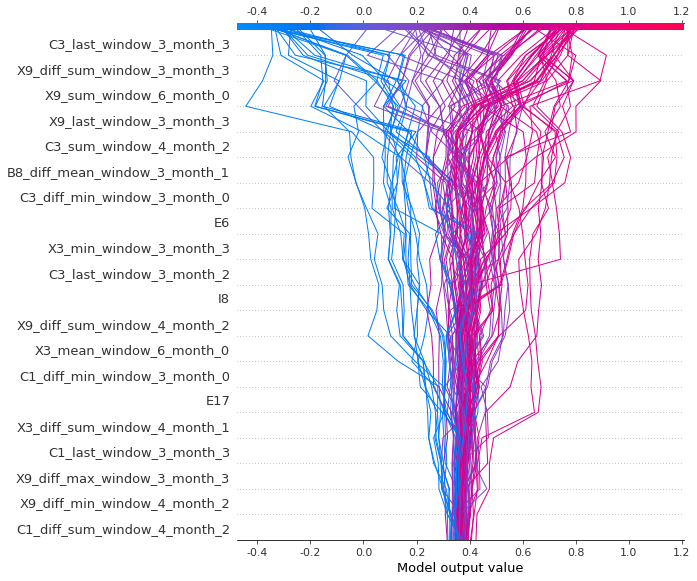

In [391]:
shap.decision_plot(explainer.expected_value,shap_values,x_train)